# 1. Price level identifier class

In [53]:
# import the necessary packages
import pandas as pd
import numpy as np
import yfinance
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.ticker as mpticker


# set the plot style
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

In [54]:
class price_level_identifier():
    def __init__(self, name, start, end, interval):
        self.name = name
        self.start = start
        self.end = end
        self.interval = interval
        
        self.levels = []
        
        self.df = self._load_df()
        
        
    def reset_data(self, name, start, end, interval):
        self.name = name
        self.start = start
        self.end = end
        self.interval = interval
        
        self.levels = []
        
        self.df = self._load_df()
        
        
    def _load_df(self):
        ticker = yfinance.Ticker(self.name)
        df = ticker.history(interval=self.interval ,start=self.start, end=self.end)
        df['Date'] = pd.to_datetime(df.index)
        df['Date'] = df['Date'].apply(mpl_dates.date2num)
        return df
    
    
    # plot the candlestick chart with price levels
    def plot_all(self):
        fig, ax = plt.subplots()
        temp = self.df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
        candlestick_ohlc(ax,temp.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
        date_format = mpl_dates.DateFormatter('%d %b %Y')
        ax.xaxis.set_major_formatter(date_format)
        fig.autofmt_xdate()
        fig.tight_layout()
        ax.set_ylabel('price')

        for level in self.levels:
            plt.hlines(level[0],xmin=min(self.df['Date']), xmax=max(self.df['Date']),colors='blue')
        fig.show()
        
        
    # Fractal method
    def fractals(self):
        self.levels = []
        df = self.df
        
        # determine whether the candle is support or resistance
        for i in range(2, df.shape[0]-2):
            isSupport = (df['Low'][i] < df['Low'][i-1])  and (df['Low'][i] < df['Low'][i+1]) and (df['Low'][i+1] < df['Low'][i+2]) and (df['Low'][i-1] < df['Low'][i-2])
            isResistance = (df['High'][i] > df['High'][i-1])  and (df['High'][i] > df['High'][i+1]) and (df['High'][i+1] > df['High'][i+2]) and (df['High'][i-1] > df['High'][i-2])
            
            if isSupport:
                self.levels.append([df['Low'][i]])
            elif isResistance:
                self.levels.append([df['High'][i]])
        return self.levels
    
    
    # find optimum K clusters for K-means model
    def get_optimum_clusters(self, df):
        wcss = []  # within-cluster sum of squares error
        k_models = []
        
        size = min(11, len(df))
        for i in range(1, size):
            kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
            kmeans.fit(df)
            wcss.append(kmeans.inertia_)
            k_models.append(kmeans)
            
        # scale down wcss
        wcss = np.array(wcss)
        wcss = (wcss - min(wcss)) / (max(wcss)-min(wcss))
        
        # find the optimum K clusters that has lowest Sum of squared error
        optimum_k = np.argmin(wcss)
        optimum_clusters = k_models[optimum_k]
            
        return optimum_clusters
    
    
    # K-means clustering
    def kmeans_model(self):
        self.levels = []
        
        lows = np.reshape(self.df['Low'].values, (-1,1))
        highs = np.reshape(self.df['High'].values, (-1,1))
        
        # using price lows to find support
        low_clusters = self.get_optimum_clusters(lows)
        low_centers = low_clusters.cluster_centers_

        # using price high to find resistance
        high_clusters = self.get_optimum_clusters(highs)
        high_centers = high_clusters.cluster_centers_

        self.levels = np.concatenate((low_centers, high_centers), axis=0)
        
        return self.levels
    
    
    # fractal method + K-means clustering
    def fractal_kmeans(self):
        # identify all possible key price levels based on the fractal method
        levels = self.fractals()
        
        # group the similar price levels using K-means clustering
        optimum_clusters = self.get_optimum_clusters(levels)
        self.levels = optimum_clusters.cluster_centers_
        
        return self.levels

# 2. Testing

In [55]:
# initialize the price level identifier
SPY = price_level_identifier('SPY', '2022-01-01', '2022-12-31', '1d')

## 2.1 Fractal method

In [56]:
# All possible key price levels found by the fractal method
SPY.fractals()

[[470.52169490180637],
 [447.60239645142053],
 [463.87531522933574],
 [412.4686651990643],
 [449.09246239691777],
 [448.85716121989327],
 [439.2306903892004],
 [402.5481334950524],
 [432.4176684951186],
 [407.59659757027157],
 [454.3718295357344],
 [436.0816669214742],
 [428.35261192317125],
 [442.51273236850005],
 [398.2722607321668],
 [422.5017530053057],
 [378.7333123737365],
 [401.76316894640365],
 [388.2799000052048],
 [385.79119064608494],
 [366.43448624232917],
 [395.2127603856337],
 [426.3711649576888],
 [414.7472339559923],
 [406.61944216647487],
 [369.1891901345196],
 [354.05671164884535],
 [376.28934011387855],
 [360.50242016362586],
 [365.70852151791433],
 [398.94842795887587],
 [399.5632436658277],
 [390.01371568540424],
 [406.5741775356228],
 [388.36760286549344],
 [407.0600969357978]]

C:\Users\Tom\AppData\Local\Temp\ipykernel_23412\2491518970.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


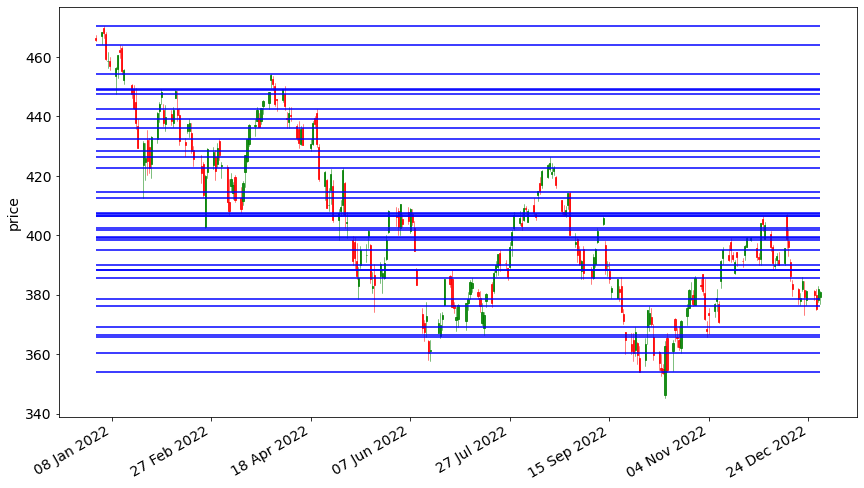

In [57]:
# plot the price levels of the fractal method
SPY.plot_all()

## 2.2 K-means clustering 

In [58]:
# All possible key price levels found by K-means clustering using price lows and price highs
SPY.kmeans_model()

array([[388.33324797],
       [420.31357575],
       [445.12918996],
       [367.63374872],
       [409.24256377],
       [377.63155491],
       [356.36279114],
       [433.69553001],
       [459.31039704],
       [400.2133072 ],
       [408.40556246],
       [451.22119856],
       [384.6259971 ],
       [420.06202391],
       [374.94876296],
       [441.04053065],
       [395.87463084],
       [464.94491916],
       [430.77288121],
       [365.0495129 ]])

C:\Users\Tom\AppData\Local\Temp\ipykernel_23412\2491518970.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


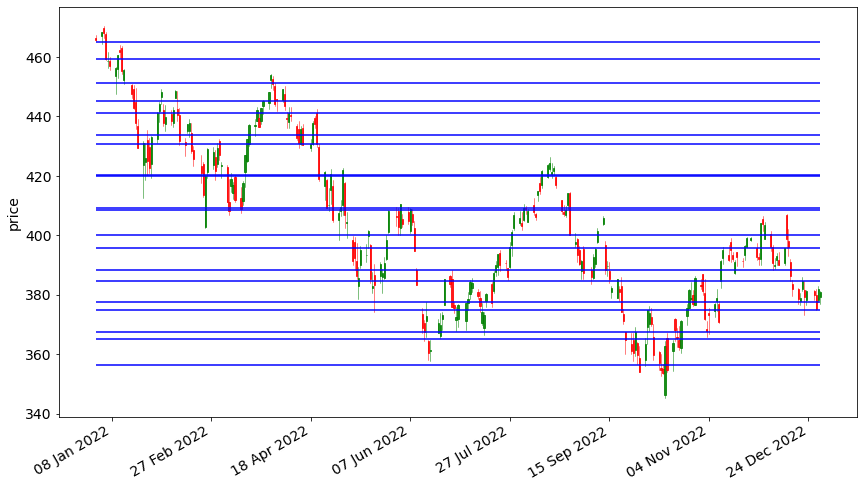

In [59]:
# plot the price levels of K-means clustering
SPY.plot_all()

## 2.3 Fractal method + K-means clustering

In [60]:
# All possible key price levels found by the fractal method and K-means clustering
SPY.fractal_kmeans()

array([[449.9809624 ],
       [388.1131023 ],
       [425.7418433 ],
       [409.17770223],
       [367.11073263],
       [467.19850507],
       [437.56068954],
       [357.27956591],
       [399.38466586],
       [377.51132624]])

C:\Users\Tom\AppData\Local\Temp\ipykernel_23412\2491518970.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


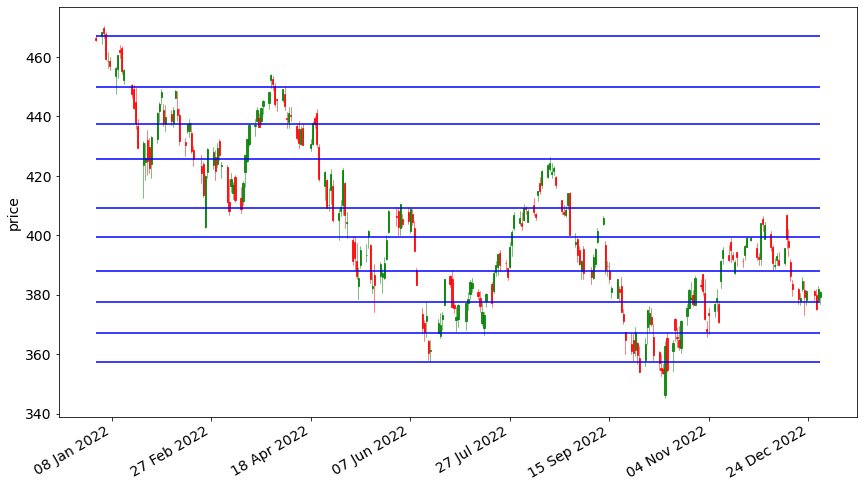

In [61]:
# plot the price levels of the fractal method and K-means clustering
SPY.plot_all()